In [3]:
import os
import sys
import argparse
import numpy as np
import pandas as pd
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt 

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.backends.cudnn as cudnn


from pytvision.transforms.aumentation import  ObjectImageMetadataTransform
from pytvision.transforms import transforms as mtrans

sys.path.append('../')
from torchlib.datasets.fersynthetic  import SyntheticFaceDataset
from torchlib.datasets.factory  import FactoryDataset


In [8]:
from aug import get_transforms_aug, get_transforms_det


In [4]:

import os
import numpy as np
import cv2
import random

import torch.utils.data as data


from torchlib.transforms.ferrender import Generator

from pytvision.datasets import imageutl as imutl
from pytvision.datasets import utility
from pytvision.transforms import functional as F


from pytvision.transforms.aumentation import(     
     ObjectImageMaskAndWeightTransform, 
     ObjectImageTransform, 
     ObjectImageAndLabelTransform, 
     ObjectImageAndMaskTransform, 
     ObjectRegressionTransform, 
     ObjectImageAndAnnotations,
     ObjectImageAndMaskMetadataTransform,
    )



In [5]:
pathnamedata  = '~/.datasets'
pathnameback  = '~/.datasets/coco'
imsize        = 64
num_channels = 3

## Train analysis

In [79]:
data=FactoryDataset.factory(
    pathname=pathnamedata, 
    name=FactoryDataset.ck, 
    subset=FactoryDataset.training, 
    download=True 
    )

dataset = SyntheticFaceDataset(
    data,
    pathnameback,
    generate='image_and_mask',
    iluminate=True, angle=45, translation=0.2, warp=0.1, factor=0.2,
)

# dataset = SyntheticFaceDataset(
#     data,
#     pathnameback,
#     ext='jpg',
#     count=2000,
#     generate='image_and_mask',
#     iluminate=True, angle=30, translation=0.2, warp=0.1, factor=0.2,
#     transform_data=get_transforms_aug(imsize),
#     transform_image=get_transforms_det(imsize),
# )

In [80]:


def lincomb(im1,im2,mask,alpha=0.5):
    im = im1.copy()     
    row, col = np.where(mask != 0)
    for i in range( len(row) ):
        r,c = row[i],col[i]
        im[r,c,0] = im1[r,c,0]*(1-alpha) + im2[r,c,0]*(alpha)
        im[r,c,1] = im1[r,c,1]*(1-alpha) + im2[r,c,1]*(alpha)
        im[r,c,2] = im1[r,c,2]*(1-alpha) + im2[r,c,2]*(alpha)
    return im

def setcolor(im, mask, color):    
    tmp=im.copy()
    tmp=np.reshape( tmp, (-1, im.shape[2])  )   
    mask = np.reshape( mask, (-1,1))      
    tmp[ np.where(mask>0)[0] ,:] = color
    im=np.reshape( tmp, (im.shape)  )
    return im

def makecolormask( mask, color=[1,0,0] ):
    colormask = np.zeros( (mask.shape[0], mask.shape[1], 3) )    
    colormask = setcolor(colormask, mask, color )        
    return colormask



In [94]:
np.random.seed(102)
idx = np.random.randint( len(data) ) 
idx

256

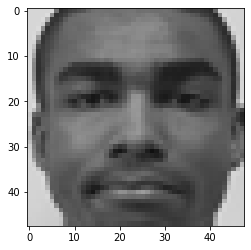

In [98]:
for idx in range(len(data)):
    image_real, label = data[idx]
    if label == 7:
        break
plt.imshow(image_real)

In [99]:
# image = utility.to_channels(image_real, num_channels)

In [100]:
image_org, image_syn, mask, meta, idxk = dataset[idx]   
image_org.shape, image_syn.shape, mask.shape

idxk 66758


((148, 148, 3), (148, 148, 3), (148, 148, 2))

In [101]:
back = dataset.databack[idxk]
back = F.resize_image(back, image_org.shape[0],image_org.shape[1], resize_mode='crop', interpolate_mode=cv2.INTER_LINEAR);
back = utility.to_channels(back, 3)

In [102]:
label

7

(148, 148, 3)
(148, 148, 2) 0.0 1.0
[1.10723177 0.06348764 0.32199573 0.11879018 1.04237393 0.05409329]


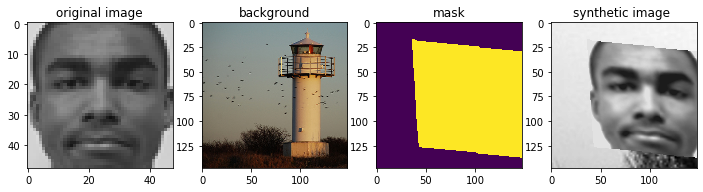

In [103]:

# image_org, image, mask, meta = dataset[idx]   
label = meta[0]
theta = meta[1:]
#x_org, x_img, y_mask, y_lab

# print(idx)
print(image_syn.shape)
print(mask.shape, mask.min(), mask.max() )
print(theta)

mask_ = mask[:,:,1]
# colormask = makecolormask( mask, color=[1,0,0] )

plt.figure( figsize=(12,10) )
plt.subplot(141)
plt.imshow(image_real)
plt.title("original image")

plt.subplot(142)
plt.imshow(back)
plt.title("background")

plt.subplot(143)
plt.imshow(mask_)
plt.title("mask")

plt.subplot(144)
plt.imshow(image_syn)
plt.title("synthetic image ")


#plt.imshow( lincomb( image/255, colormask, mask, alpha=0.3 ) )
# plt.imshow(mask, cmap='seismic', alpha=0.2)
plt.savefig("ferp_synthetic2.png", dpi=800, bbox_inches = 'tight')

In [52]:
plt.imsave("ck_synthetic.png")

<Figure size 864x1368 with 0 Axes>

In [9]:
import cv2

# Hs = np.array([[1,1,0],[1,1,0],[0,0,0]] )
# Hr = np.concatenate( (theta[0],[[0,0,1]]),axis=0 )  
# Ht = np.concatenate( (theta[1],[[0,0,1]]),axis=0 )
# Hw = np.concatenate( (theta[2],[[0,0,1]]),axis=0 )
# H = Hw.dot( Ht.dot( Hr) ) 
# H_inv = (np.linalg.inv( H ))[:2,:] 
# print(H_inv)

print(theta)
H_inv = theta.reshape( 2,3 ) 
# H_inv = np.array([1,0,0,0,1,0]).reshape( (2,3) ).astype('float')
print(H_inv.shape)

dh,dw,dc = image.shape
img = cv2.warpAffine(image, H_inv, (dw,dh) )

plt.imshow(img)


[  0.77755435  -0.66591631 158.96291074   0.57042365   0.79313178
 -34.88293825   0.           0.           1.        ]


ValueError: cannot reshape array of size 9 into shape (2,3)

[[ 0.86542376  0.28810756 -0.29203146]
 [-0.40244815  0.87961239 -0.38458924]]
torch.Size([1, 3, 148, 148])
torch.Size([1, 2, 3])
tensor([[[ 0.8654,  0.2881, -0.2920],
         [-0.4024,  0.8796, -0.3846]]], device='cuda:0')
torch.Size([1, 3, 148, 148])
torch.Size([148, 148, 3])


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

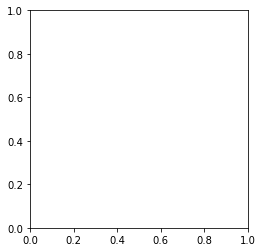

In [7]:
import torch.nn.functional as FF
import skimage.transform as trans

def param2theta(param, w, h):
    param = np.linalg.inv(param)
    theta = np.zeros([2,3])
    theta[0,0] = param[0,0]
    theta[0,1] = param[0,1]*h/w
    theta[0,2] = param[0,2]*2/w + param[0,0] + param[0,1] - 1
    theta[1,0] = param[1,0]*w/h
    theta[1,1] = param[1,1]
    theta[1,2] = param[1,2]*2/h + param[1,0] + param[1,1] - 1
    return theta

#H = np.array([1,0,0,0,1,0])
dh,dw,dc = image.shape
# H = param2theta( theta.reshape( (3,3) ), dw, dh )
H = theta.reshape( (2,3) )
print(H)

img_ts = torch.from_numpy( image.transpose( (2,0,1) ) ).unsqueeze(0).float()
theta_ts = torch.from_numpy( H ).float()
theta_ts = theta_ts.view( 1,2,3 )

img_ts = img_ts.cuda()
theta_ts = theta_ts.cuda()


print(img_ts.shape)
print(theta_ts.shape)
print(theta_ts)

grid = FF.affine_grid( theta_ts, img_ts.size())
img = FF.grid_sample(img_ts, grid )
print(img.shape)
img = img.permute( 2,3,1,0 ).squeeze(3)
print(img.shape)

plt.imshow(img/255)




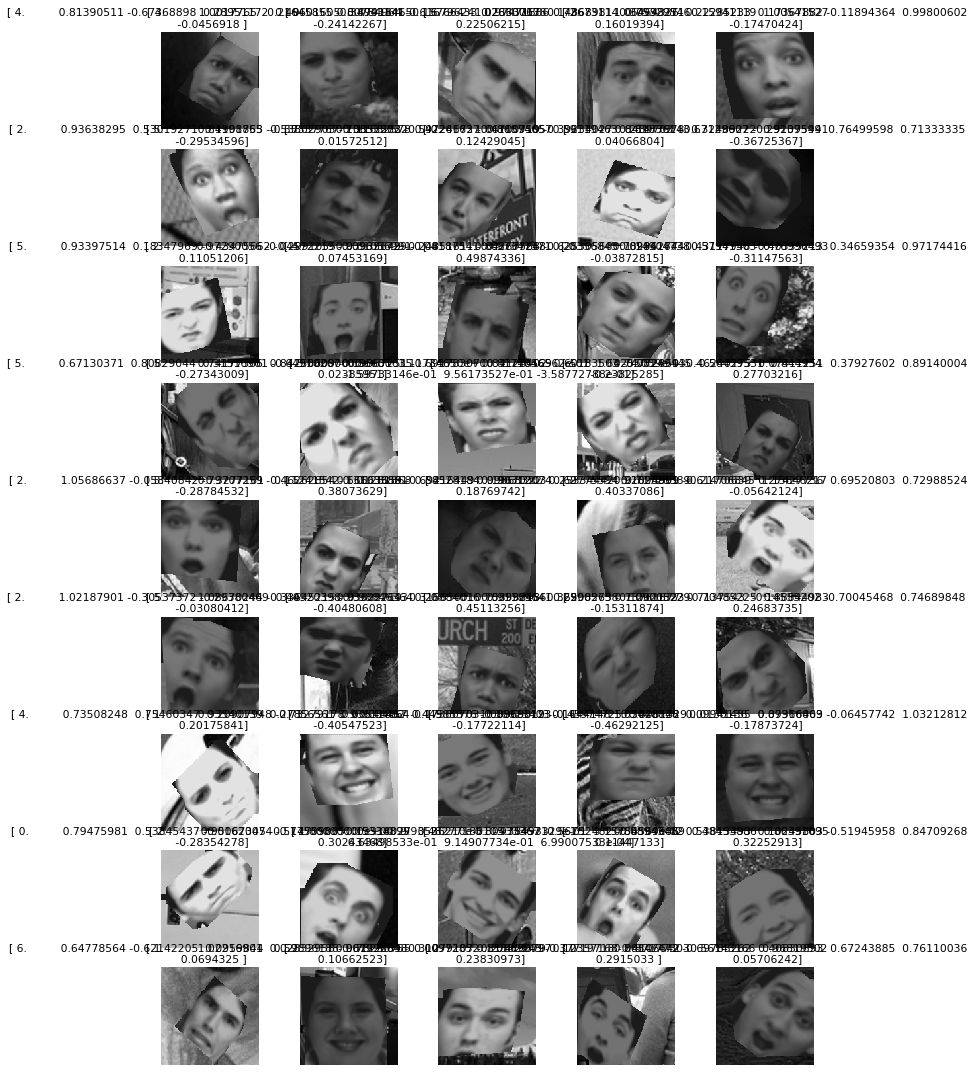

In [8]:
import matplotlib
matplotlib.rcParams['font.size'] = 9
matplotlib.rcParams['figure.figsize'] = (12,19)

numRows = 9; numCols = 5

plt.figure()
for k in range(numRows*numCols):
    image_org, image, mask, label = dataset[ np.random.randint( len(dataset) )  ]  
    plt.subplot(numRows,numCols,k+1); 
    plt.imshow( image )
    #plt.imshow( mask[:,:,1], cmap='seismic', alpha=0.2)
    plt.title( label ); 
    plt.axis('off')
    

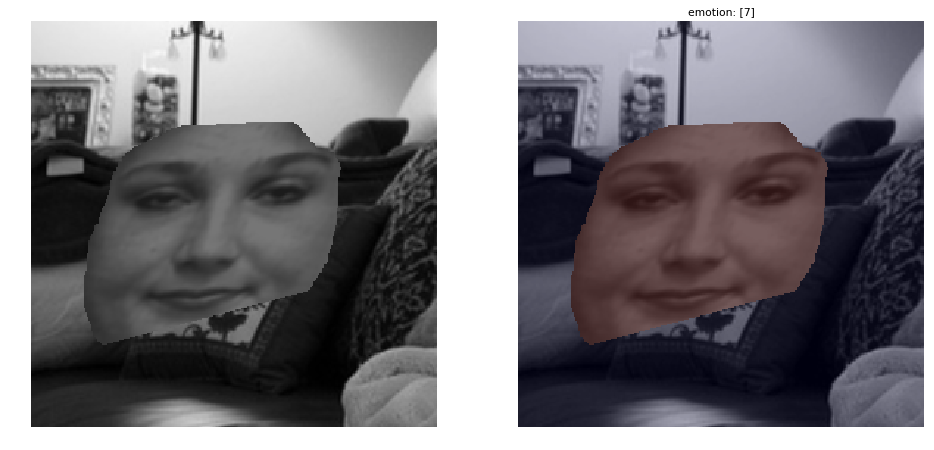

In [9]:
image, mask, label = dataset[ np.random.randint( len(dataset) )  ] 

plt.figure( figsize=(16,8) )
plt.subplot(121)
plt.imshow(image/255)
# plt.title( name )
plt.axis('off')
plt.subplot(122)
plt.imshow(image)
plt.imshow(mask[:,:,1], cmap='seismic', alpha=0.2)
plt.title( 'emotion: {}'.format(label) )
plt.axis('off')
plt.show()


In [23]:
def maggradient(image):
    gI = np.gradient(image)
    divI =  (gI[0]**2 + gI[1]**2)**0.5 
    mg  = np.sum(divI>0.001)/np.prod(divI.shape)
    return mg


In [4]:
data=FactoryDataset.factory(
    pathname=pathnamedata, 
    name=FactoryDataset.bu3dfe, 
    subset=FactoryDataset.training, 
    download=True 
    )

dataset = SyntheticFaceDataset(
    data,
    pathnameback,
    generate='image_and_mask',
    iluminate=True, angle=45, translation=0.3, warp=0.2, factor=0.2,
    transform_image=transforms.Compose([            

        mtrans.ToResize( (64,64), resize_mode='square', padding_mode=cv2.BORDER_REPLICATE), 
        #mtrans.ToRandomTransform( mtrans.VFlip(), prob=0.5 ),         
        mtrans.ToTensor(),
        mtrans.ToMeanNormalization( mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], )
        #mtrans.ToNormalization(),
        ]),
    
    transform_data=transforms.Compose([            

        mtrans.ToResize( (64,64), resize_mode='square', padding_mode=cv2.BORDER_REPLICATE), 
        #mtrans.ToRandomTransform( mtrans.VFlip(), prob=0.5 ), 
        
        mtrans.ToRandomTransform( mtrans.RandomBrightness( factor=0.30 ), prob=0.50 ),
        mtrans.ToRandomTransform( mtrans.RandomContrast( factor=0.30 ), prob=0.50 ),
        mtrans.ToRandomTransform( mtrans.RandomGamma( factor=0.30 ), prob=0.50 ),
        mtrans.ToRandomTransform( mtrans.RandomRGBPermutation(), prob=0.50 ),
        #mtrans.ToRandomTransform( mtrans.CLAHE(), prob=0.25 ),
        #mtrans.ToRandomTransform(mtrans.ToGaussianBlur( sigma=0.2 ), prob=0.50 ),
        mtrans.ToRandomTransform(mtrans.ToGaussianNoise( sigma=0.05 ), prob=0.750 ),
        
        mtrans.ToTensor(),
        mtrans.ToMeanNormalization( mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], )
        #mtrans.ToNormalization(),
        ])
)

dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=4 )
print( len(dataset) )


519


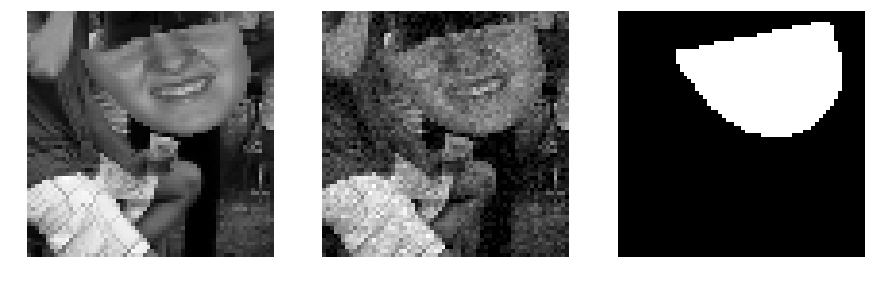

In [17]:

x_org, x_img, y_mask, y_lab = dataset[0]

orign = x_org[0,...]
image = x_img[0,...]
mask  = y_mask[1,...]

plt.figure( figsize=(15,15) )
plt.subplot(131)
plt.imshow(orign,cmap='gray')
plt.axis('off')
plt.ioff()

plt.subplot(132)
plt.imshow(image,cmap='gray')
plt.axis('off')
plt.ioff()  

plt.subplot(133)
plt.imshow(mask,cmap='gray')
plt.axis('off')
plt.ioff()      

plt.show() 


torch.Size([4, 3, 128, 128]) torch.Size([4, 2, 128, 128]) torch.Size([4, 1])


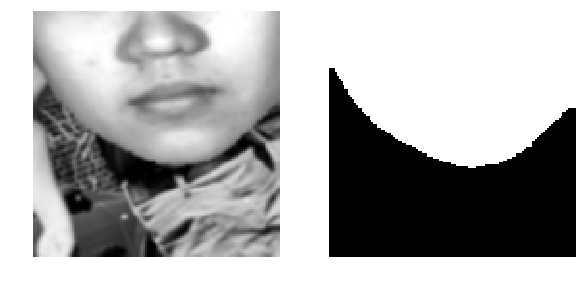

torch.Size([4, 3, 128, 128]) torch.Size([4, 2, 128, 128]) torch.Size([4, 1])


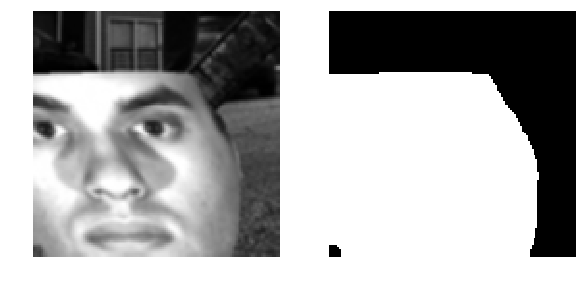

torch.Size([4, 3, 128, 128]) torch.Size([4, 2, 128, 128]) torch.Size([4, 1])


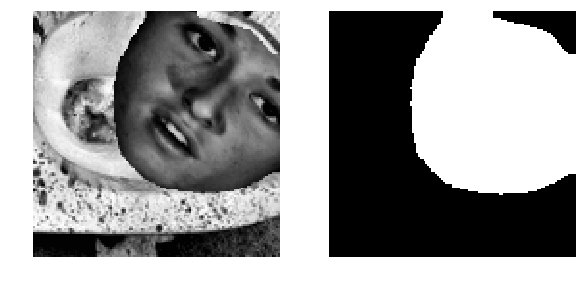

torch.Size([4, 3, 128, 128]) torch.Size([4, 2, 128, 128]) torch.Size([4, 1])


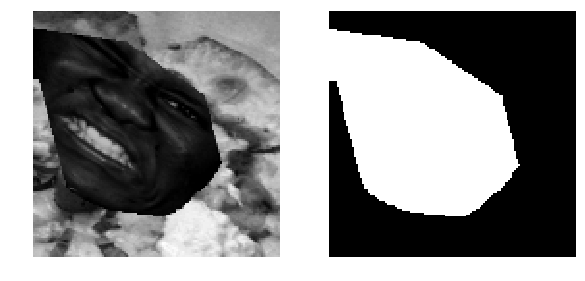

In [6]:


label_batched = []
for i_batch, (x_img, y_mask, y_lab) in enumerate(dataloader):
    print(x_img.shape, y_mask.shape, y_lab.shape)
    
    image = x_img[0,0,...]
    mask  = y_mask[0,1,...]
    
    # observe 4th batch and stop.
     
        
    plt.figure( figsize=(15,15) )
    plt.subplot(131)
    plt.imshow(image,cmap='gray')
    plt.axis('off')
    plt.ioff()

    plt.subplot(132)
    plt.imshow(mask,cmap='gray')
    plt.axis('off')
    plt.ioff()        
    plt.show()   
        
    if i_batch == 3:
        break
    
    